<a href="https://colab.research.google.com/github/deep-works/Project-College-Campus-Navigation/blob/main/final_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

DATA_PATH = ''
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    DATA_PATH = root_path + "/Proj1_CGC_Building_with_sides_classify"
    for filename in os.listdir(DATA_PATH):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
ALL_IMG_DATA
RUN_THIS_all_in_1_changable_parameter_(2_output).ipynb
ALL_IMG_DATA.csv
.old_no_side_one_output_classify
make_csv_data_from_all_img_data.ipynb
project_1_ppt.gslides
final_projeci1_ppt.gslides
ResNet18(ptrain)_2-output_accy-88_(lr-0.0001_bs-32_ep-20_sd-2025).pth
final_project_1.ipynb
Project_report_1.gdoc


## Importing pytorch and setup CPU or GPU

In [ ]:
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Define DEVICE (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


#### Setup random state

In [ ]:
# define the random seed
SEED = 2025

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

# Data Importing(csv) and Modification(custom dataset) and Loading

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display

# Load the CSV data into a DataFrame
df = pd.read_csv(DATA_PATH+"/ALL_IMG_DATA.csv")
# display(df.head())
display(df)

#  --- Derive ALL unique categories from the FULL DataFrame ---
BUILDING_CATEGORIES = sorted(df['class'].unique().tolist())
FACADE_CATEGORIES = sorted(df['subclass'].unique().tolist())

print("Master Building Categories:", BUILDING_CATEGORIES)
print("Master Facade Categories:", FACADE_CATEGORIES)

,path,class,subclass
0,/ALL_IMG_DATA/gurudeb_front/gurudeb_005.jpeg,gurudeb,front
1,/ALL_IMG_DATA/gurudeb_front/gurudeb_004.jpeg,gurudeb,front
2,/ALL_IMG_DATA/gurudeb_front/frame_0210.jpg,gurudeb,front
3,/ALL_IMG_DATA/gurudeb_front/gurudeb_002.jpeg,gurudeb,front
4,/ALL_IMG_DATA/gurudeb_front/gurufront_00040.jpeg,gurudeb,front
...,...,...,...
361,/ALL_IMG_DATA/chemistry_left/chemleft_00024.jpeg,chemistry,left
362,/ALL_IMG_DATA/chemistry_left/chemleft_00025.jpeg,chemistry,left
363,/ALL_IMG_DATA/chemistry_left/chemleft_00026.jpeg,chemistry,left
364,/ALL_IMG_DATA/chemistry_left/chemleft_00027.jpeg,chemistry,left


Master Building Categories: ['admin', 'chemistry', 'gurudeb', 'heritage']
Master Facade Categories: ['front', 'left', 'right']


## Train-Test Split

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['subclass'])

print('------------ Training set subclass frequencies within each class ----------------')
print(train_df.groupby('class')['subclass'].value_counts().sort_index())
print('------------ Test set subclass frequencies within each class ----------------')
print(test_df.groupby('class')['subclass'].value_counts().sort_index())

------------ Training set subclass frequencies within each class ----------------
class      subclass
admin      front       27
           left        21
           right       25
chemistry  front       31
           left        28
           right       28
gurudeb    front       33
           left        22
           right       26
heritage   front       25
           left        26
Name: count, dtype: int64
------------ Test set subclass frequencies within each class ----------------
class      subclass
admin      front       7
           left        6
           right       7
chemistry  front       9
           left        7
           right       9
gurudeb    front       8
           left        5
           right       4
heritage   front       6
           left        6
Name: count, dtype: int64


## Define Data Transformations (Data Augmentation)

Data transformations are applied to the training images to artificially increase the size and variability of the dataset.
- This helps the model become more robust and generalize better to unseen images.
- By introducing variations like *rotations, flips, color changes, and affine transformations,* **we prevent the model from overfitting to the specific characteristics of the original training data.**
- This is particularly important for smaller datasets.

**For the test set,** only basic transformations like *resizing and normalization* are applied to ***prepare the images for the model without altering their content.***

In [ ]:
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]
px=256

train_transform = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(10),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    # transforms.RandomAffine(degrees=0),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

print(train_transform)

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Make Custom Dataset to load with `torch`

### Custom dataset maker class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class MakeTorchDataset(Dataset):
    def __init__(self, dataframe, image_base_path=DATA_PATH,
    building_categories=BUILDING_CATEGORIES, facade_categories=FACADE_CATEGORIES,
    transform=None):
        self.dataframe = dataframe
        self.image_base_path = image_base_path
        self.transform = transform
        # Create mappings for class and subclass based on the *provided* category lists
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(building_categories)}
        self.subclass_to_idx = {sub_name: i for i, sub_name in enumerate(facade_categories)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_full_path = self.image_base_path+self.dataframe.iloc[idx]['path']
        # print(img_full_path)
        image = Image.open(img_full_path).convert('RGB')

        # Access labels by column name for clarity and robustness
        building_class_name = self.dataframe.iloc[idx]['class']
        facade_subclass_name = self.dataframe.iloc[idx]['subclass']

        # Convert string labels to integer indices using the pre-defined mappings
        building_class_label = self.class_to_idx[building_class_name]
        facade_subclass_label = self.subclass_to_idx[facade_subclass_name]

        if self.transform: image = self.transform(image) # apply transformation

        return image, building_class_label, facade_subclass_label

### Create train and test dataset

In [ ]:
train_dataset = MakeTorchDataset(dataframe=train_df, transform=train_transform)
test_dataset = MakeTorchDataset(dataframe=test_df, transform=test_transform)

print("Building Categories:", train_dataset.class_to_idx)
print("Facade Categories:", train_dataset.subclass_to_idx)

Building Categories: {'admin': 0, 'chemistry': 1, 'gurudeb': 2, 'heritage': 3}
Facade Categories: {'front': 0, 'left': 1, 'right': 2}


## Data loader

### Define ***Batch-Size (Hyper-parameter)***

The batch size is a hyperparameter that defines the **number of samples** that will be propagated through the network at once during training.

- **Larger batch sizes:**
  - can lead to faster training per epoch due to **better utilization of hardware**,
  - but they require more memory and might converge to sharper minima, *which may **not generalize as well**.*
- **Smaller batch sizes:**
  - introduce more noise in the gradient updates,
  - which can help the *model escape local minima* and potentially lead to **better generalization**,
  - but training can be **slower**.

In [ ]:
BATCH_SIZE = 32

### Create DataLoader instances

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Example of iterating through the DataLoader
# Unpack all three values returned by the dataset's __getitem__
for images, building_labels, facade_labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of building labels shape: {building_labels.shape}")
    print(f"Batch of facade labels shape: {facade_labels.shape}")
    break
     # Just show one batch

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of building labels shape: torch.Size([32])
Batch of facade labels shape: torch.Size([32])


### Visualization of transformation

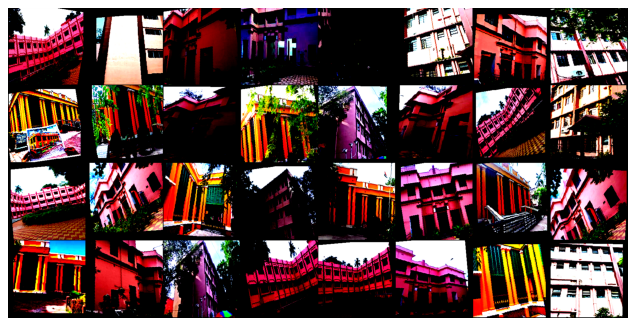

Building labels: tensor([2, 0, 1, 1, 0, 0, 1, 0, 3, 3, 1, 3, 0, 1, 2, 0, 2, 1, 3, 0, 3, 1, 3, 1,
        3, 1, 0, 2, 2, 1, 3, 0])
Facade labels: tensor([1, 2, 2, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 2, 1, 1, 1, 0, 1, 2,
        1, 1, 1, 1, 2, 1, 1, 0])


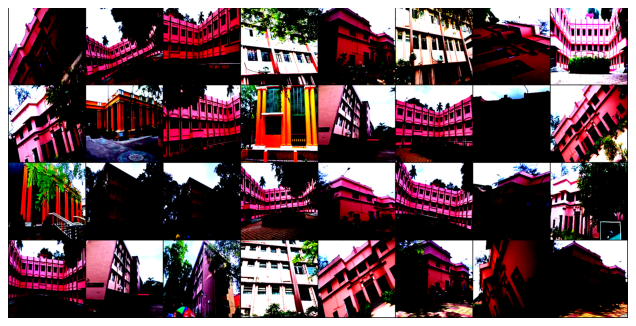

Building labels: tensor([1, 2, 2, 0, 1, 0, 1, 2, 1, 3, 2, 3, 0, 2, 1, 1, 3, 0, 0, 2, 1, 2, 1, 1,
        2, 0, 0, 0, 1, 1, 1, 1])
Facade labels: tensor([0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 2,
        0, 2, 1, 0, 0, 1, 2, 1])


In [ ]:
def disp_img_grid(dataloader, mean, std):
    batch = next(iter(dataloader))
    # Unpack all three values returned by the DataLoader
    img, building_lbl, facade_lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=8)
    plt.figure(figsize=(10, 10), dpi=80)

    # Ensure the pixel values are within the displayable range [0, 1] or [0, 255]
    # Clamping to [0, 1] is usually sufficient for imshow
    grid = torch.clamp(grid, 0, 1)

    plt.imshow(grid.permute(1, 2, 0).numpy()) # c0/h1/w2 -> h0/w1/c2
    plt.axis('off')
    plt.show()
    # Decide which label to print (e.g., the building label)
    print(f'Building labels: {building_lbl}')
    print(f'Facade labels: {facade_lbl}')


# Example usage with your existing DataLoaders:
disp_img_grid(train_loader, mean=mean, std=standev)
disp_img_grid(test_loader, mean=mean, std=standev)

# CNN Defining Part

In [ ]:
# Load torch's ResNet18 model
import torchvision.models as models
import torch.nn as nn

# CNN_MODEL = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
CNN_MODEL = models.resnet18(weights = None) # pretrained = False)
# CNN_MODEL = models.efficientnet_b4(weights = '') # pretrained = False)

This code freezes the parameters of the pre-trained ResNet model, except for the final classification layer.

- This is a common technique in **transfer learning**, where you leverage the learned features from a large dataset and only train the last layer on your specific task.
- This *helps prevent overfitting* on **smaller datasets** and speeds up training.

> [!NOTE]  
>**If you use a pretrained model (`weights ='ResNet18_Weights.DEFAULT'`),**  
>you ***might freeze*** some layers (`requires_grad = False`) to keep their learned features and only train the new layers.  

> [!NOTE]  
>**If you train a model from scratch (`weights = None`)**,   
>you train all layers, so you ***don't freeze*** any parameters (`requires_grad = True` by default).




In [ ]:
# Freeze all parameters in the feature extraction layers
# for param in CNN_MODEL.parameters():
#     param.requires_grad = False

## Modify the last layer for **Two Output** (building+facade)


#### Custom TwoOutput class

The `TwoOutputs` class is a custom PyTorch module designed to provide two distinct outputs from a single input. This is useful in scenarios where you want a model to perform two related but separate tasks simultaneously. In this case, it's used for classifying buildings and their facades/directions.


In [ ]:
import torch.nn as nn

# A class contains Linear and ReLU modules to create two classification heads.
# The class provides two outputs building and its facade:
class TwoOutputs(nn.Module):
    def __init__(self, in_feature, mid_feature, num_building_classes, num_facade_classes):
        # init super class..
        super().__init__()

        # Building Classification Head
        self.building_head = nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=mid_feature),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=mid_feature, out_features=num_building_classes)
            # softmax12 = nn.Softmax(dim=1) # handels by CrossEntropyLoss()
        )
        # Facade/Direction/Side Prediction Head
        self.facade_head = nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=mid_feature),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=mid_feature, out_features=num_facade_classes)
            # softmax12 = nn.Softmax(dim=1) # handels by CrossEntropyLoss()
        )

    # Feed-forward function for the two classification heads.
    def forward(self, x):
        building_logits = self.building_head(x)
        facade_logits = self.facade_head(x)
        return building_logits, facade_logits

**Key Components:**

- `nn.Linear(in_features=in_feature, out_features=mid_feature):` This is a linear transformation layer that takes the input features (in_feature) and transforms them into a mid_feature dimensional output. This layer performs a weighted sum of the inputs and adds a bias.
- `nn.ReLU():` This is the Rectified Linear Unit activation function. It introduces non-linearity to the model, allowing it to learn more complex patterns. It simply outputs the input if it's positive, and zero otherwise.
- `nn.Dropout(p=0.2):` Dropout is a regularization technique. During training, it randomly sets a fraction (p=0.2 means 20%) of the input units to zero at each update. This helps prevent overfitting by making the network less reliant on specific neurons.
- `nn.Linear(in_features=mid_feature, out_features=num_building_classes):` Another linear layer that takes the output of the previous layers `(mid_feature)` and transforms it into an output with the dimension equal to the number of building classes `(num_building_classes)`. The output of this layer represents the raw scores `(logits)` for each building class.

- The commented-out line `# softmax12 =  nn.Softmax(dim=1) #` handels by `CrossEntropyLoss()` indicates that a Softmax activation is typically used after the final linear layer in classification tasks to convert logits into probabilities. However, in this setup, the CrossEntropyLoss function is likely being used, which internally applies Softmax, so an explicit Softmax layer here is not needed.


The forward method defines how data flows through the module. When you call an instance of the TwoOutputs class with an input, this method is executed.

- It takes the input x (which is expected to come from a previous layer of a larger network).
- `self.building_head(x)` passes the input x through the sequence of layers defined in the building_head. The result, building_logits, is the output of the building classification head.
- `self.facade_head(x)` passes the input x through the sequence of layers defined in the facade_head. The result, facade_logits, is the output of the facade classification head.
- The method returns a tuple containing both the `building_logits` and `facade_logits`. These outputs will then be used in the training process, typically with separate loss functions for each task

#### Apply last layer modifications

In [ ]:
# modifying the last layer to two output
# ResNet models have a 'fc' layer as the last linear layer
last_layer_in = CNN_MODEL.fc.in_features
num_building_classes = len(BUILDING_CATEGORIES)  # len(train_dataset.class_to_idx)
num_facade_classes = len(FACADE_CATEGORIES) # Get the number of facade classes
new_mid_layer_out = 256

print(f"last layer output for model = {last_layer_in} -> {new_mid_layer_out} -> convert to {num_building_classes} and {num_facade_classes} outputs")

# CNN_MODEL.fc = nn.Linear(last_layer_in, no_of_classes)
# Correct the variable name and add the facade class argument
CNN_MODEL.fc = TwoOutputs(last_layer_in, new_mid_layer_out, num_building_classes, num_facade_classes) # two output

last layer output for model = 512 -> 256 -> convert to 4 and 3 outputs


## Model's Weights and biases Initialization

- Without preseted weights, your model starts with essentially random or default values.  
- Proper initialization helps ensure that the initial weights are in a range that allows for stable and efficient training.
- If the weights are not initialized appropriately, the gradients can become too small (vanishing) or too large (exploding) during backpropagation,  
making it difficult for the model to learn effectively.


- **Kaiming Normal Initialization (`init.kaiming_normal_`):**
  - Used ***for weights.***
  - This method is particularly effective for layers that use the ReLU activation function,
  - Helping to prevent issues like **vanishing or exploding gradients** during training.
- **Normal Initialization (`init.normal_`):**
   - Used ***for biases***. Biases are
   - initialized with small random values.
   - Proper initialization is important for training deep learning models efficiently and effectively.

In [ ]:
import torch.nn.init as init

for module in CNN_MODEL.fc.modules(): # init weight and bias of only fc layer
# for module in CNN_MODEL.modules():  # init all cause `weights=None`
    if isinstance(module, nn.Linear):
        init.kaiming_normal_(
            module.weight, a=0, mode='fan_out', nonlinearity='relu',
        )
        if module.bias is not None:
            fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
            bound = 1 / (fan_out)**0.5
            init.normal_(module.bias, -bound, bound)

### Send the model to GPU/CPU

In [ ]:
# Move model to DEVICE
CNN_MODEL = CNN_MODEL.to(DEVICE)
print(CNN_MODEL)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Parameter settings

### Define loss function
For *a **classification task** like this, **CrossEntropyLoss** is a common and effective choice.*
- It combines LogSoftmax and NLLLoss in one single class.
- The output of the model (logits) is compared to the true labels, and the loss
- represents the error between the predicted probabilities and the actual class.

In [ ]:
# criterion = torch.nn.CrossEntropyLoss()
building_loss_fn = nn.CrossEntropyLoss()
facade_loss_fn = nn.CrossEntropyLoss()
print(building_loss_fn)
# print(CNN_MODEL)

CrossEntropyLoss()


### ***(learning rate)*** Define Hyper-parameter

The learning rate is a hyperparameter that *controls how much the model's
weights are updated during training based on the calculated gradients.*

- **A smaller learning rate** means smaller updates, which can lead to more stable
training but may take longer to converge.
- **A larger learning rate** can speed up
convergence but might overshoot the optimal weights.

In [ ]:
# set hyperparameter
LEARNING_RATE = 0.0001

### Define optimizer
The optimizer is **responsible for updating the model's weights during training** based on the ***calculated gradients.***   

The choice of optimizer can depend on the specific task, dataset, and model architecture.**Adam** is often a good default choice, but experimenting with others like **SGD** with momentum can sometimes yield better results.

In [ ]:
import torch.optim as optim

# Adam Optimizer..
optimizer = optim.Adam(CNN_MODEL.parameters(), lr=LEARNING_RATE)

# SGD with momentum
# optimizer = optim.SGD(CNN_MODEL.parameters(), lr=LEARNING_RATE, momentum=0.9)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


### Learning Rate Scheduler(not used)



A learning rate scheduler is a tool used during the training of a neural network to adjust the learning rate according to a predefined schedule or strategy. The learning rate determines the step size at which the model's weights are updated based on the calculated gradients.

In the code, `torch.optim.lr_scheduler.StepLR` is used, which decays the learning rate by `gamma` every `step_size` epochs.

In [ ]:
# import torch.optim.lr_scheduler as lr_scheduler

# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training-Validate Part

## Defining functions for train and validation

### function for training

Modify the train_NN function to unpack the output of the model and only use the first element (the building classification output) when calculating the loss.

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

def train_NN(model, train_loader, test_loader, optimizer, device=DEVICE,
building_categories=BUILDING_CATEGORIES, facade_categories=FACADE_CATEGORIES, n_epochs=10):

    # Store individual lists for plotting later
    loss_graph_list, valid_loss_list = [], []
    building_accy_list, facade_accy_list = [], []

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        training_loss = []

        # Assuming train_loader yields (image, building_label, facade_label)
        for i_image, i_building_label, i_facade_label in train_loader:
            # Move data to the specified device
            i_image = i_image.to(device)
            i_building_label = i_building_label.to(device)
            i_facade_label = i_facade_label.to(device)

            optimizer.zero_grad()  # Zero out the gradients to prevent accumulation

            # Get model's multi-head output
            output_building, output_facade = model(i_image)

            # Calculate loss for each head
            loss_building = building_loss_fn(output_building, i_building_label)
            loss_building.backward(retain_graph=True)
            loss_facade = facade_loss_fn(output_facade, i_facade_label)
            loss_facade.backward()

            # Combine losses (e.g., simple average or weighted average)
            # Summing losses and then calling backward once is generally more efficient.
            total_loss = (loss_building + loss_facade) / 2
            # total_loss.backward()  # Perform backpropagation for the combined loss

            optimizer.step()  # Update the model's weights using the optimizer

            training_loss.append(total_loss.item())

        print(f"Training loss at iteration--{epoch+1} is:- {np.mean(training_loss)}")
        loss_graph_list.append(np.mean(training_loss))

        # Call the multi-head evaluation function
        building_accy, facade_accy, current_valid_loss = eval_model_on_test(model, test_loader)
        valid_loss_list.append(current_valid_loss)
        building_accy_list.append(building_accy)
        facade_accy_list.append(facade_accy)

    print("Training done.....................")

    # Return detailed logs to plot them later
    return {"train_loss": loss_graph_list,
            "val_loss": valid_loss_list,
            "building_accy": building_accy_list,
            "facade_accy": facade_accy_list}

### Function for validation test

You will also need to make a similar change in the eval_model_on_test function to handle the tuple output from the model when calculating the validation loss and determining the predicted class for the building classification.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report

# Assuming DEVICE is globally defined or passed as an argument when calling this function.

def eval_model_on_test(model, test_loader, device=DEVICE,
building_categories=BUILDING_CATEGORIES, facade_categories=FACADE_CATEGORIES, disp_confusion_matrix=False):

    model.eval()  # Set the model to evaluation mode
    # Lists to store actual and predicted labels for confusion matrices for both tasks
    actual_building_labels = []
    predicted_building_labels = []
    actual_facade_labels = []
    predicted_facade_labels = []
    validation_loss = [] # list to store the total validation loss for each batch

    with torch.no_grad(): # Disable gradient calculations during evaluation
        # Assuming test_loader yields (image, building_label, facade_label)
        for i_image, i_building_label, i_facade_label in test_loader:
            # Move data to the specified device
            i_image = i_image.to(device)
            i_building_label = i_building_label.to(device)
            i_facade_label = i_facade_label.to(device)

            # Get model's multi-head output
            output_building, output_facade = model(i_image)

            # Calculate loss for each head and combine them (e.g., average)
            loss_building = building_loss_fn(output_building, i_building_label)
            loss_facade = facade_loss_fn(output_facade, i_facade_label)
            total_loss = (loss_building + loss_facade) / 2 # Average the losses
            validation_loss.append(total_loss.item())

            # Get predictions for building task
            _, predicted_building = torch.max(output_building.data, 1)
            actual_building_labels.extend(i_building_label.cpu().numpy())
            predicted_building_labels.extend(predicted_building.cpu().numpy())

            # Get predictions for facade task
            _, predicted_facade = torch.max(output_facade.data, 1)
            actual_facade_labels.extend(i_facade_label.cpu().numpy())
            predicted_facade_labels.extend(predicted_facade.cpu().numpy())

    # Calculate accuracies for each task using sklearn.metrics.accuracy_score
    building_accuracy = accuracy_score(actual_building_labels, predicted_building_labels) * 100.0
    facade_accuracy = accuracy_score(actual_facade_labels, predicted_facade_labels) * 100.0

    average_validation_loss = np.mean(validation_loss)

    print(f' --Validation Loss: {average_validation_loss}', end='')
    print(f'  --Building Accuracy: {building_accuracy:.2f}%', end='')
    print(f'  --Facade Accuracy: {facade_accuracy:.2f}%')

    if disp_confusion_matrix:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
        # Confusion Matrix for Building Classification on the first subplot (ax1)
        ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix(actual_building_labels, predicted_building_labels),
            display_labels=[str(label) for label in building_categories] # Use defined building categories
        ).plot(cmap='Blues', ax=ax1) # Specify ax=ax1 to plot on the first subplot
        ax1.tick_params(axis='x', rotation=90) # Rotate x-axis labels for readability on ax1
        ax1.set_title("Building Classification")

        # Confusion Matrix for Facade Classification on the second subplot (ax2)
        ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix(actual_facade_labels, predicted_facade_labels),
            display_labels=[str(label) for label in facade_categories] # Use defined facade categories
        ).plot(cmap='Greens', ax=ax2) # Specify ax=ax2 to plot on the second subplot
        ax2.tick_params(axis='x', rotation=90) # Rotate x-axis labels for readability on ax2
        ax2.set_title("Facade Classification")

        plt.tight_layout() # Adjust layout to prevent overlap
        plt.show()

        # Assuming you have actual_building_labels, predicted_building_labels,
        # actual_facade_labels, and predicted_facade_labels from eval_model_on_test
        print("\n--- Building Classification Report ---")
        print(classification_report(actual_building_labels, predicted_building_labels, target_names=BUILDING_CATEGORIES))

        print("\n--- Facade Classification Report ---")
        print(classification_report(actual_facade_labels, predicted_facade_labels, target_names=FACADE_CATEGORIES))

    # Return both accuracies and the average loss
    return building_accuracy, facade_accuracy, average_validation_loss

## Training the CNN model

tune hyperparameter for experiment

- random state [change SEED](#scrollTo=Setup_random_state)
- batch size [change BATCH SIZE](#scrollTo=Define_Batch_Size_Hyper_parameter_)
- learning rate [change LEARNING RATE](#scrollTo=Define_Hyper_parameter_learning_rate_)
- learning-rate scheduler [enable/disable](#scrollTo=Learning_Rate_Scheduler) not used
- no of epoches or iteration


In [ ]:
# Set no of epoches or train iteration
ITERATION = 20
# call train funtion
result = train_NN(
    CNN_MODEL, train_loader, test_loader, optimizer, n_epochs=ITERATION,
)

Training loss at iteration--1 is:- 6.160528206825257
 --Validation Loss: 3.755736509958903  --Building Accuracy: 37.84%  --Facade Accuracy: 35.14%
Training loss at iteration--2 is:- 4.4408937215805055
 --Validation Loss: 8.098599433898926  --Building Accuracy: 41.89%  --Facade Accuracy: 29.73%
Training loss at iteration--3 is:- 2.866530013084412
 --Validation Loss: 5.067033608754476  --Building Accuracy: 58.11%  --Facade Accuracy: 40.54%
Training loss at iteration--4 is:- 3.897656798362732
 --Validation Loss: 1.9230057795842488  --Building Accuracy: 86.49%  --Facade Accuracy: 58.11%
Training loss at iteration--5 is:- 3.257633018493652
 --Validation Loss: 1.3407373627026875  --Building Accuracy: 87.84%  --Facade Accuracy: 75.68%
Training loss at iteration--6 is:- 2.5048524141311646
 --Validation Loss: 2.939601500829061  --Building Accuracy: 64.86%  --Facade Accuracy: 64.86%
Training loss at iteration--7 is:- 1.830733746290207
 --Validation Loss: 0.7728577057520548  --Building Accuracy: 

In [ ]:
result

{'train_loss': [np.float64(6.160528206825257),
  np.float64(4.4408937215805055),
  np.float64(2.866530013084412),
  np.float64(3.897656798362732),
  np.float64(3.257633018493652),
  np.float64(2.5048524141311646),
  np.float64(1.830733746290207),
  np.float64(2.1439600706100466),
  np.float64(1.91783167719841),
  np.float64(1.3694861859083176),
  np.float64(1.8174694359302521),
  np.float64(1.647824913263321),
  np.float64(1.074640840291977),
  np.float64(1.362665206193924),
  np.float64(1.0372953534126281),
  np.float64(0.904785332083702),
  np.float64(1.2307540833950044),
  np.float64(0.8341016948223114),
  np.float64(0.8501414477825164),
  np.float64(0.8031626373529435)],
 'val_loss': [np.float64(3.755736509958903),
  np.float64(8.098599433898926),
  np.float64(5.067033608754476),
  np.float64(1.9230057795842488),
  np.float64(1.3407373627026875),
  np.float64(2.939601500829061),
  np.float64(0.7728577057520548),
  np.float64(1.1256808241208394),
  np.float64(0.8484523495038351),
  

## Visualize train, validation loss vs accuracy wrt epoches

### Visualization function (plotting fn)

In [ ]:
import matplotlib.pyplot as plt

def ploting(ax, arr, color, lname, ylabel='loss', xlabel='epoch'):
    ax.plot(arr, color=color, label=lname)
    ax.scatter(range(len(arr)), arr, color=color, s=20) # Added marker size for better visibility
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xlabel(xlabel)


def plot_classifier_results(results_dict, classifier_name):
    train_loss = results_dict['train_loss']
    valid_loss = results_dict['val_loss']
    building_accy = results_dict['building_accy']
    facade_accy = results_dict['facade_accy']

    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=85)
    ax2 = ax1.twinx() # Create a second y-axis that shares the same x-axis

    # Plot Losses on ax1 (left y-axis)
    ploting(ax1, train_loss, color='red', lname=f'Training Loss', ylabel='Loss')
    ploting(ax1, valid_loss, color='purple', lname=f'Validation Loss', ylabel='Loss')
    # Plot Accuracies on ax2 (right y-axis)
    ploting(ax2, facade_accy, color='green', lname=f'Facade Accuracy(%)', ylabel='Accuracy(%)') # New plot for facade accuracy
    ploting(ax2, building_accy, color='blue', lname=f'Building Accuracy(%)', ylabel='Accuracy(%)')

    # Combine handles and labels from both axes for a single legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles1 + handles2, labels1 + labels2, loc='lower left')
    plt.title(f'Training/Validation Loss and Accuracies per Epoch ({classifier_name})')
    plt.tight_layout() # Adjust layout to make space for the legend
    plt.show()

### Plot the train results

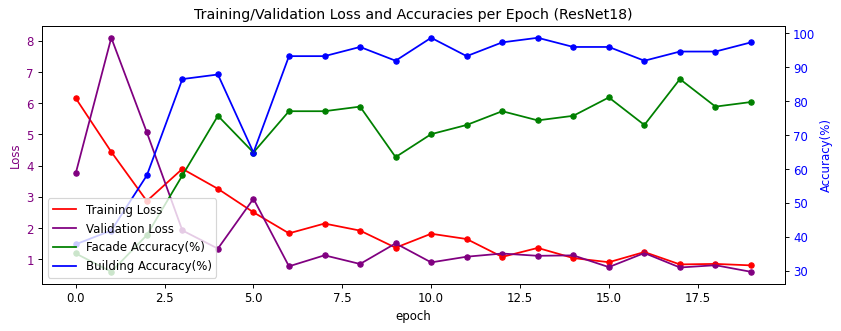

In [ ]:
plot_classifier_results(result, 'ResNet18')

## Validate the model

 --Validation Loss: 0.5968362353742123  --Building Accuracy: 97.30%  --Facade Accuracy: 79.73%


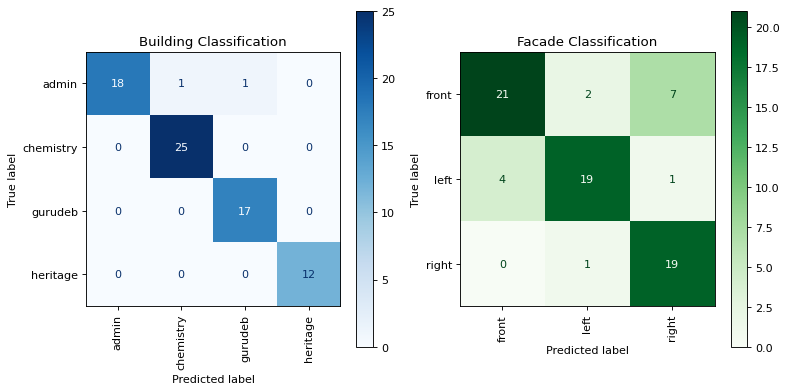


--- Building Classification Report ---
              precision    recall  f1-score   support

       admin       1.00      0.90      0.95        20
   chemistry       0.96      1.00      0.98        25
     gurudeb       0.94      1.00      0.97        17
    heritage       1.00      1.00      1.00        12

    accuracy                           0.97        74
   macro avg       0.98      0.97      0.97        74
weighted avg       0.97      0.97      0.97        74


--- Facade Classification Report ---
              precision    recall  f1-score   support

       front       0.84      0.70      0.76        30
        left       0.86      0.79      0.83        24
       right       0.70      0.95      0.81        20

    accuracy                           0.80        74
   macro avg       0.80      0.81      0.80        74
weighted avg       0.81      0.80      0.80        74


Avg Accuracy: 88.51%


In [ ]:
# call evaluation function
ac1,ac2,_ = eval_model_on_test(
    CNN_MODEL,test_loader, disp_confusion_matrix=True,
)
accuracy=(ac1+ac2)/2
print(f'\nAvg Accuracy: {accuracy:.2f}%')

## Save trained model

In [ ]:
# print(CNN_MODEL.state_dict())
# torch.save(CNN_MODEL.state_dict(), DATA_PATH +'/resnet18_image_classifier.pth')

#save entire model
model_name = CNN_MODEL.__class__.__name__ + '18_2-output' # change according to which used (18,34,50,152)
# model_name = CNN_MODEL.__class__.__name__ + '18_2-output'

# generate save file name with hyperparameters
filename = f"{model_name}_accy-{int(accuracy)}_(lr-{LEARNING_RATE}_bs-{BATCH_SIZE}_ep-{ITERATION}_sd-{SEED}).pth"

# save only if get a higher accuracy
if accuracy > 50:
    torch.save(CNN_MODEL, DATA_PATH + '/' + filename)
    print(model_name,' saved as', filename)

os.listdir(DATA_PATH)

ResNet18(ptrain)_2-output  saved as ResNet18(ptrain)_2-output_accy-88_(lr-0.0001_bs-32_ep-20_sd-2025).pth


['ALL_IMG_DATA',
 'RUN_THIS_all_in_1_changable_parameter_(2_output).ipynb',
 'ALL_IMG_DATA.csv',
 '.old_no_side_one_output_classify',
 'make_csv_data_from_all_img_data.ipynb',
 'project_1_ppt.gslides',
 'final_projeci1_ppt.gslides',
 'ResNet18(ptrain)_2-output_accy-88_(lr-0.0001_bs-32_ep-20_sd-2025).pth',
 'final_project_1.ipynb',
 'Project_report_1.gdoc']

# Individual testing

## Predefined parameters

In [ ]:
# MODEL = DATA_PATH+"/resnet18_image_classifier_full.pth"
MODEL = CNN_MODEL
TRANSFORM = test_transform
# Update the CATEGORIES variable to be a list of keys
categories = list(test_dataset.class_to_idx.keys())
facade_categories = ['front', 'left', 'right']
print(categories)
print(facade_categories)


['admin', 'chemistry', 'gurudeb', 'heritage']
['front', 'left', 'right']


## Function for individual image classification

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Classify a single image
def classify_this_image(img_path, model=MODEL,img_transform=TRANSFORM):
    model.eval() # Set the model to evaluation mode
    try:
        image = Image.open(DATA_PATH+img_path).convert('RGB') # Load image
        plt.figure(dpi=50) # Set figure size
        plt.imshow(image) # Display the image
        plt.axis('off') # Turn off axis labels
        plt.show() # <--- ADDED LINE: Show the plot
        image = img_transform(image).unsqueeze(0).to(DEVICE) # Apply transforms and add batch dim, move to device
    except FileNotFoundError:
        print(f"Error: Image not found at {img_path}")
        return None, None, None, None
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None, None, None, None

    with torch.no_grad(): # Disable gradient calculations
        output_building, output_facade = model(image) # Get model outputs

        probabilities1 = torch.softmax(output_building, dim=1) # Apply softmax to building output to get probabilities
        probabilities2 = torch.softmax(output_facade, dim=1) # Apply softmax to facade output to get probabilities

        # For debugging/inspection:
        print("Building Probabilities:", probabilities1)
        print("Facade Probabilities:", probabilities2)

        _, predicted_class_index = torch.max(probabilities1, 1) # Get predicted building class index
        _, predicted_side_index = torch.max(probabilities2, 1) # Get predicted facade class index

        predicted_building_class = categories[predicted_class_index.item()] # Get predicted building class name
        predicted_facade_side = facade_categories[predicted_side_index.item()] # <--- MODIFIED LINE: Get predicted facade class name

        print(f"Predicted building class: {predicted_building_class} & the predicted facade side is: {predicted_facade_side}") # <--- MODIFIED LINE: Print both predictions

        # return predicted_building_class, predicted_facade_side, probabilities1, probabilities2
        return {
            'building_class': predicted_building_class,'facade_side': predicted_facade_side,
            'probabilities_1': probabilities1,'probabilities_2': probabilities2
        }

## Input image and Classify

In [ ]:
os.listdir(DATA_PATH)

['ALL_IMG_DATA',
 'RUN_THIS_all_in_1_changable_parameter_(2_output).ipynb',
 'ALL_IMG_DATA.csv',
 '.old_no_side_one_output_classify',
 'make_csv_data_from_all_img_data.ipynb',
 'project_1_ppt.gslides',
 'final_projeci1_ppt.gslides',
 'ResNet18(ptrain)_2-output_accy-88_(lr-0.0001_bs-32_ep-20_sd-2025).pth',
 'final_project_1.ipynb',
 'Project_report_1.gdoc']

### Actual what to do .. direction identification


In [ ]:
def get_navigational_guidance(model_prediction, target_building):
    """
    Provides navigational guidance based on the predicted building and facade,
    and the target building.

    Args:
        predicted_building (str): The predicted class of the building.
        predicted_facade (str): The predicted facade/side of the building.
        target_building (str): The building the user wants to reach.

    Returns:
        str: Navigational guidance string.
    """
    predicted_building = model_prediction["building_class"]
    predicted_facade = model_prediction["facade_side"]

    if predicted_building == target_building:
        if predicted_facade == 'front':
            return f"You are looking at the Front of the {target_building.capitalize()} Building. You have arrived!"
        elif predicted_facade == 'left':
            return f"You are looking at the Left side of the {target_building.capitalize()} Building. Turn right to face the front."
        elif predicted_facade == 'right':
            return f"You are looking at the Right side of the {target_building.capitalize()} Building. Turn left to face the front."
        else:
            return f"You are at the {target_building.capitalize()} Building, but the facade is unclear."
    else:
        # Define navigational guidance based on standpoint (predicted building and facade)
        #  'current_position': {
        #         'position_side': {
        #             'wanna_go_to_admin_building': 'Turn left',
        #             'wanna_go_to_chemistry_building': 'Go straight',
        #             'wanna_go_to_gurudeb_building': 'Go straight'
        #         },
        nav_guidance_map = {
            'heritage': {
                'front': {
                    'admin': 'Turn left',
                    'chemistry': 'Go straight',
                    'gurudeb': 'Go straight and Turn left and Go'
                },
                'right': {
                    'admin': 'Turn right',
                    'chemistry': 'Turn left',
                    'gurudeb': 'Turn left'
                }
            },
            'chemistry': {
                'front': {
                    'admin': 'Go behind',
                    'heritage': 'Turn right',
                    'gurudeb': 'Go straight' # Assuming gurudeb and chemistry are somewhat aligned
                },
                 'left': {
                    'admin': 'Go behind',
                    'heritage': 'Turn right',
                    'gurudeb': 'Turn right'
                },
                'right': {
                    'admin': 'Go behind',
                    'heritage': 'Turn left',
                    'gurudeb': 'Turn left'
                }
            },
             'admin': {
                 'front': {
                    'heritage': 'Turn left',
                    'chemistry': 'Go behind',
                    'gurudeb': 'Go behind'
                },
                 'left': {
                    'heritage': 'Go straight', # Assuming admin left is towards heritage
                    'chemistry': 'Turn right',
                    'gurudeb': 'Turn right'
                },
                'right': {
                    'heritage': 'Turn right',
                    'chemistry': 'Turn left',
                    'gurudeb': 'Turn left'
                }
            },
             'gurudeb': {
                 'front': {
                    'admin': 'Go out, to other campus',
                    'chemistry': 'Go out, to other campus',
                    'heritage': 'Go out, to other campus'
                },
                'left': {
                    'admin': 'Go out, to other campus',
                    'chemistry': 'Go out, to other campus',
                    'heritage': 'Go out, to other campus'
                },
                 'right': {
                    'admin': 'Go out, to other campus',
                    'chemistry': 'Go out, to other campus',
                    'heritage': 'Go out, to other campus'
                }
            }
        }

        if predicted_building in nav_guidance_map and predicted_facade in nav_guidance_map[predicted_building] and target_building in nav_guidance_map[predicted_building][predicted_facade]:
            direction = nav_guidance_map[predicted_building][predicted_facade][target_building]
            return f"You are currently looking at the {predicted_building.capitalize()} Building's {predicted_facade.capitalize()} side. To get to the {target_building.capitalize()} Building, {direction}."
        else:
            return f"You are currently looking at the {predicted_building.capitalize()} Building's {predicted_facade.capitalize()} side. Navigation to the {target_building.capitalize()} Building from here is not explicitly defined."

# Example usage (assuming you have model_prediction from classify_this_image)
# out = classify_this_image("/../Testing_data_mix/Heritage_test/fview_0001.jpg")
# target_building = 'admin'
# guidance = get_navigational_guidance(out, target_building)
# print(guidance)

### Main Application


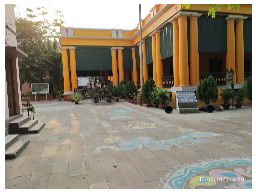

Building Probabilities: tensor([[2.5676e-11, 2.0271e-18, 3.6772e-15, 1.0000e+00]], device='cuda:0')
Facade Probabilities: tensor([[1.0000e+00, 1.5160e-12, 7.7152e-10]], device='cuda:0')
Predicted building class: heritage & the predicted facade side is: front
You are currently looking at the Heritage Building's Front side. To get to the Admin Building, Turn left.
You are currently looking at the Heritage Building's Front side. To get to the Chemistry Building, Go straight.
You are currently looking at the Heritage Building's Front side. To get to the Gurudeb Building, Go straight and Turn left and Go.


In [ ]:
# Call the classification function
out = classify_this_image("/../Testing_data_mix/Heritage_test/fview_0001.jpg")
print(get_navigational_guidance(out, 'admin'))
print(get_navigational_guidance(out, 'chemistry'))
print(get_navigational_guidance(out, 'gurudeb'))

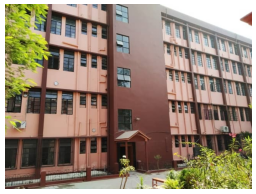

Building Probabilities: tensor([[9.9852e-01, 1.4791e-03, 9.2309e-09, 1.9625e-15]], device='cuda:0')
Facade Probabilities: tensor([[9.9996e-01, 2.0935e-10, 4.3619e-05]], device='cuda:0')
Predicted building class: admin & the predicted facade side is: front


'You are looking at the Front of the Admin Building. You have arrived!'

In [ ]:
out = classify_this_image("/../Testing_data_mix/Admin_test/campus-admin-building.jpg")
get_navigational_guidance(out, 'admin')

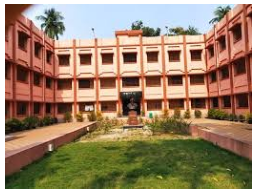

Building Probabilities: tensor([[1.3102e-22, 2.2490e-19, 1.0000e+00, 0.0000e+00]], device='cuda:0')
Facade Probabilities: tensor([[9.9999e-01, 9.5628e-15, 6.9733e-06]], device='cuda:0')
Predicted building class: gurudeb & the predicted facade side is: front


"You are currently looking at the Gurudeb Building's Front side. To get to the Admin Building, Go out, to other campus."

In [ ]:
out = classify_this_image("/../Testing_data_mix/Gurudeb_test/images (2).jpeg")
get_navigational_guidance(out, 'admin')

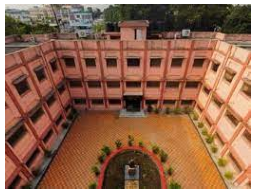

Building Probabilities: tensor([[3.8214e-25, 1.1995e-22, 1.0000e+00, 1.2036e-40]], device='cuda:0')
Facade Probabilities: tensor([[9.9951e-01, 4.5995e-04, 2.6813e-05]], device='cuda:0')
Predicted building class: gurudeb & the predicted facade side is: front


"You are currently looking at the Gurudeb Building's Front side. To get to the Admin Building, Go out, to other campus."

In [ ]:
out = classify_this_image("/../Testing_data_mix/Gurudeb_test/images (3).jpeg")
get_navigational_guidance(out, 'admin')

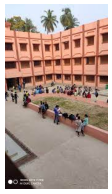

Building Probabilities: tensor([[3.8156e-22, 4.5695e-22, 1.0000e+00, 0.0000e+00]], device='cuda:0')
Facade Probabilities: tensor([[9.9999e-01, 9.2777e-13, 9.7821e-06]], device='cuda:0')
Predicted building class: gurudeb & the predicted facade side is: front


"You are currently looking at the Gurudeb Building's Front side. To get to the Admin Building, Go out, to other campus."

In [ ]:
out = classify_this_image("/../Testing_data_mix/Gurudeb_test/images (4).jpeg")
get_navigational_guidance(out, 'admin')

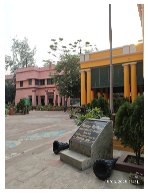

Building Probabilities: tensor([[2.7973e-07, 1.0000e+00, 9.5752e-07, 2.6475e-09]], device='cuda:0')
Facade Probabilities: tensor([[1.0000e+00, 1.3282e-13, 8.3594e-08]], device='cuda:0')
Predicted building class: chemistry & the predicted facade side is: front


"You are currently looking at the Chemistry Building's Front side. To get to the Admin Building, Go behind."

In [ ]:
out = classify_this_image("/../Testing_data_mix/Heritage_test/Copy of diagonal_0002.jpg")
get_navigational_guidance(out, 'admin')

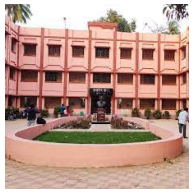

Building Probabilities: tensor([[2.8158e-19, 1.6698e-09, 1.0000e+00, 1.5766e-41]], device='cuda:0')
Facade Probabilities: tensor([[0.0984, 0.0010, 0.9006]], device='cuda:0')
Predicted building class: gurudeb & the predicted facade side is: right


"You are currently looking at the Gurudeb Building's Right side. To get to the Admin Building, Go out, to other campus."

In [ ]:
out = classify_this_image("/../Testing_data_mix/Gurudeb_test/images (5).jpeg")
get_navigational_guidance(out, 'admin')

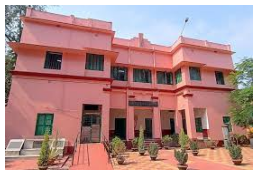

Building Probabilities: tensor([[7.1316e-26, 1.0000e+00, 7.9838e-10, 7.0968e-37]], device='cuda:0')
Facade Probabilities: tensor([[1.2305e-07, 1.0000e+00, 1.7209e-07]], device='cuda:0')
Predicted building class: chemistry & the predicted facade side is: left
You are looking at the Left side of the Chemistry Building. Turn right to face the front.
You are currently looking at the Chemistry Building's Left side. To get to the Gurudeb Building, Turn right.


In [ ]:
out = classify_this_image("/../Testing_data_mix/Chemistry_test/images (8).jpeg")
get_navigational_guidance(out, 'admin')
print(get_navigational_guidance(out, 'chemistry'))
print(get_navigational_guidance(out, 'gurudeb'))

In [ ]:
# GradCAM